In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm
%matplotlib inline


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
#Parameters
S0 = 100        # Initial stock price
K = 100         # Strike price
T = 1.0         # Time to maturity in years
r = 0.05        # Risk-free interest rate
sigma = 0.2     # Volatility
N = 252         # Number of time steps (daily re-hedging)
dt = T / N      # Time step
#Simulating the Paths
def simulate_gbm(S0, r, sigma, T, N, num_paths):
    dt = T / N
    S = np.zeros((N+1, num_paths))
    S[0] = S0
    for t in range(1, N+1):
        Z = np.random.standard_normal(num_paths)
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S
#Let's simulate 10,000 paths.Rich Fortunoff LLC Confidential 


In [3]:
#Simulating the Paths
def simulate_gbm(S0, r, sigma, T, N, num_paths):
    dt = T / N
    S = np.zeros((N+1, num_paths))
    S[0] = S0
    for t in range(1, N+1):
        Z = np.random.standard_normal(num_paths)
        S[t] = S[t-1] * np.exp((r - 0.5 * sigma**2) * dt + sigma * np.sqrt(dt) * Z)
    return S

In [4]:
num_paths = 10000
S = simulate_gbm(S0, r, sigma, T, N, num_paths)
def black_scholes_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    call_price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    return call_price
def delta_call(S, K, T, r, sigma):
    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    delta = norm.cdf(d1)
    return delta

# Arrays to store results
PnL = np.zeros(num_paths)          # Profit and Loss from hedging
option_prices = np.zeros((N+1, num_paths))
deltas = np.zeros((N+1, num_paths))
for i in range(num_paths):
    stock_prices = S[:, i]
    # Initialize portfolio
    cash = black_scholes_call(S0, K, T, r, sigma) - delta_call(S0, K, T, r, sigma) * S0
    delta = delta_call(S0, K, T, r, sigma)
    for t in range(1, N+1):
        # Time remaining
        tau = T - t * dt
        if tau <= 0:
            tau = 0.0001  # Avoid division by zero
        # Update delta
        new_delta = delta_call(stock_prices[t], K, tau, r, sigma)
        # Rebalance portfolio
        cash = cash * np.exp(r * dt) - (new_delta - delta) * stock_prices[t]
        delta = new_delta
    # At maturity
    ST = stock_prices[-1]
    option_payoff = max(ST - K, 0)
    portfolio_value = delta * ST + cash
    PnL[i] = portfolio_value - option_payoff


In [5]:
#Standard Deviation of Hedging Error
std_error = np.std(PnL)
mean_error = np.mean(PnL)
print(f"Mean Hedging Error: {mean_error:.2f}")
print(f"Standard Deviation of Hedging Error: {std_error:.2f}")


Mean Hedging Error: 0.01
Standard Deviation of Hedging Error: 0.44


In [6]:
option_premium = black_scholes_call(S0, K, T, r, sigma)
relative_std_error = std_error / option_premium * 100
print(f"Relative Standard Deviation of Hedging Error: {relative_std_error:.2f}%")



Relative Standard Deviation of Hedging Error: 4.23%


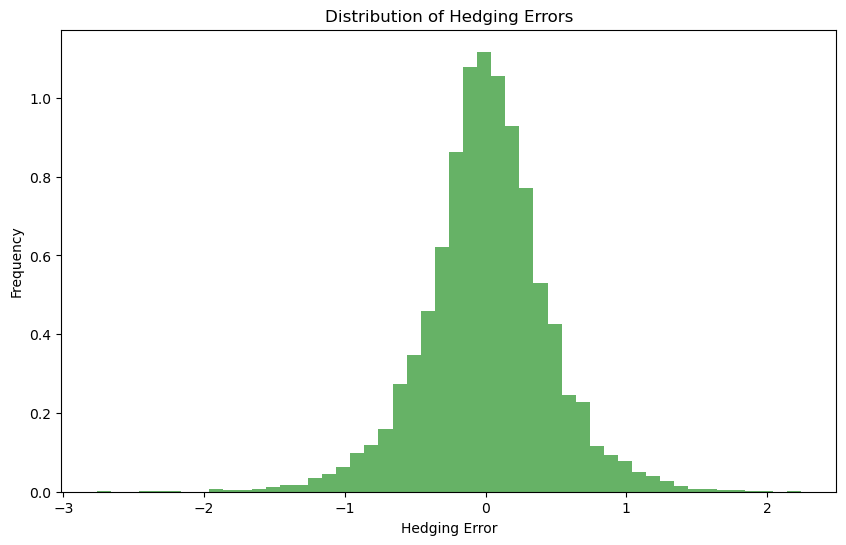

In [7]:
plt.figure(figsize=(10,6))
plt.hist(PnL, bins=50, density=True, alpha=0.6, color='g')
plt.title('Distribution of Hedging Errors')
plt.xlabel('Hedging Error')
plt.ylabel('Frequency')
plt.show()

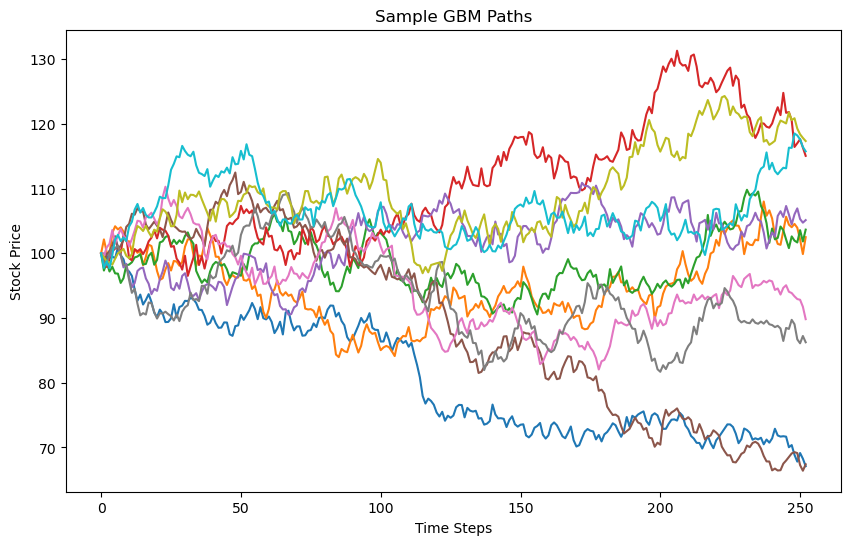

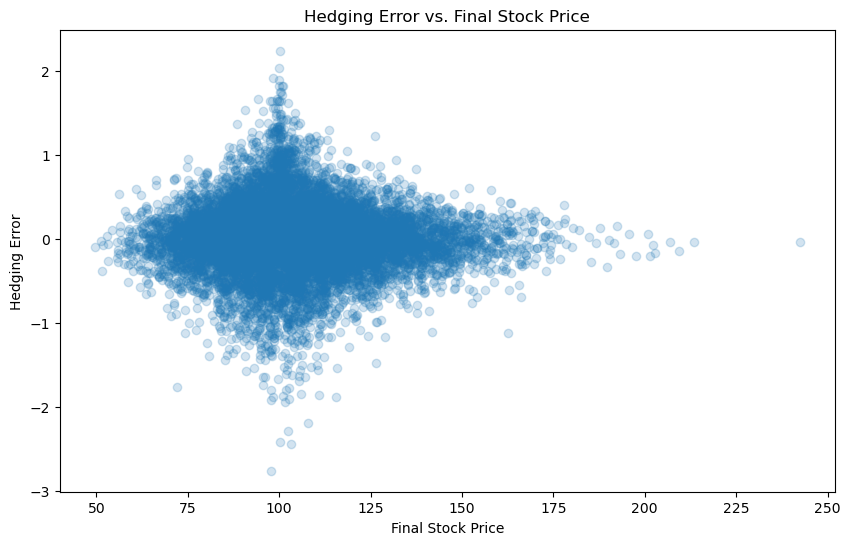

In [8]:
plt.figure(figsize=(10,6))
for i in range(10):
    plt.plot(S[:, i])
plt.title('Sample GBM Paths')
plt.xlabel('Time Steps')
plt.ylabel('Stock Price')
plt.show()
plt.figure(figsize=(10,6))
plt.scatter(S[-1], PnL, alpha=0.2)
plt.title('Hedging Error vs. Final Stock Price')
plt.xlabel('Final Stock Price')
plt.ylabel('Hedging Error')
plt.show()